## xcube Data Store Framework - Getting Started

This notebook provides a walk-through demonstrating how to use the _xcube data store framework_.

The xcube Data Store Framework provides a uniform way 
* to retrieve data using popular Python in-memory data models (e.g. xarray.Dataset, geopandas.GeoDataFrame);
* to decode/encode data from different data formats (Zarr, NetCDF, GeoJSON, Shapefiles);
* to access data from different sources (local directory, AWS S3 buckets, API-based data services).

Data stores can be used to search data, open data, write data. These operations are generic and can have store-specific parameters.
xcube uses JSON Schema to describe store-specific parameters for store initialisation, search data, open data, and write data operations.

xcube provides three data store implementations by default:
* `memory` - holds data in-memory, very useful for testing;
* `directory` - maintains data in a local filesystem directory;
* `s3` - maintains data in object storage compatible to AWS S3.

New data store implementations can be added to xcube, usually through xcube plugins. 
Since xcube 0.5, three data stores based on different data APIs are added through xcube plugins available in the [xcube GitHub organisation](https://github.com/dcs4cop):
* `sentinelhub` - Datasets from Sentinel Hub by [plugin xcube_sh](https://github.com/dcs4cop/xcube-sh) with a dedicated [Notebook](./2_sentinel_hub.ipynb)
* `cciodp` - Datasets from ESA Climate Change Initiative (CCI) by [plugin xcube_cci](https://github.com/dcs4cop/xcube-cci) with a dedicated [Notebook](./3_esa_climate_change_initiative.ipynb)
* `cds` - Datasets from the C3S Climate Data Store by [plugin xcube_cds](https://github.com/dcs4cop/xcube-cds) with a dedicated [Notebook](./4_c3s_climate_data_store.ipynb)

If you are interested in the development of new data stores for xcube, you may want to follow the [xcube data store conventions](https://github.com/dcs4cop/xcube/blob/master/docs/source/storeconv.md).

This notebook provides an introduction to the xcube data store framework by presenting some of its hight-level entry-point functions. The data store functions and methods work in the same way for all types of data stores. Only the store initialisation, open, write, and search parameters are store-specific.

In [1]:
# mandatory xcube store imports
from xcube.core.store import find_data_store_extensions
from xcube.core.store import get_data_store_params_schema
from xcube.core.store import new_data_store

# Utilities for notebook visualization. 
# JSON provides pretty-printing of Python lists and dictionaries.
from IPython.display import JSON

### Querying available data stores and instantiating a store

We start by having a look at the available data stores. This is done by calling function `find_data_store_extensions()`.

In [2]:
JSON({e.name: e.metadata for e in find_data_store_extensions()})

<IPython.core.display.JSON object>

The default data stores `memory`, `directory` and `s3` are always present. Other data stores may be appear depending on which xcube plugins have been installed.

To access the actual data, we need data store _instances_. They can be obtained by the top-level function `new_data_store(store_id, **store_params)`. It receives `store_id`, the data store's identifier, e.g. `directory`, and one or more store-specific parameters. Another function `get_data_store_params_schema(store_id)` provides a description of the store-specific parameters (as JSON Schema).

For example, which parameters are accepted by `new_data_store()` when using the `s3` data store?

In [3]:
get_data_store_params_schema('s3')

The field `properties` lists the available parameters. The field `required` lists the required parameters, only `bucket_name` is mandatory, for public buckets only. Non-public buckets would require credentials `aws_access_key_id` and `aws_sectret_access_key`.

Which parameters are accepted by `new_data_store()` when using the `directory` data store?

In [4]:
get_data_store_params_schema('directory')

The only mandatory parameter here is `base_dir` so it must be passed to `new_data_store()` to instantiate the data store. 

In [5]:
store = new_data_store('directory', base_dir='../../serve/demo')
store

### Querying the data contained in a store

The data store method `get_data_ids()` lists the available data resources as an iterator of (`data_id`, `title`) pairs. Depending The list may contain both gridded and vector datasets. The base directory used above contains three demo datasets. (Note, the `directory` store does not yet read dataset titles from file metadata, but this **will be implemented soon**):

In [6]:
list(store.get_data_ids())

[('cube-1-250-250.zarr', None),
 ('cube-5-100-200.zarr', None),
 ('cube.nc', None)]

We can obtain metadata about the data using the `describe_data(data_id)` method. This feature is **not yet fully implemented** for the `directory`store, so the returned metadata is currently limited. It returns a data descriptor object that represents the data's metadata:

In [7]:
store.describe_data('cube-1-250-250.zarr')

The type specifier value `"dataset[cube]"` tells us that the data resource `"cube-1-250-250.zarr"` will be (A) represented as an `xarray.Dataset` object and (B) uses a [data cube schema](https://github.com/dcs4cop/xcube/blob/master/docs/source/cubespec.md) once it is being accessed. Another possible type specifier is `"geodataframe"` for vector data data. In such case the data would be represented as a `geopandas.GeoDataFrame`.

We can also search in stores. However this features is **not yet fully implemented**. What works for most stores is searching without any search parameters:

In [8]:
search_result = list(store.search_data())
search_result

As search results may be huge, both the `get_data_ids()` and `search_data()` methods return iterators instead of lists or tuples. That's why we use the `list` function above to be able to print the results in this notebook. Search results are also data descriptor objects:

In [9]:
search_result[0]

### Opening data from a store

The store's `open_data(data_id, **open_params)` method is used to access the data:

In [10]:
dataset = store.open_data('cube-1-250-250.zarr')
dataset

<xarray.Dataset>
Dimensions:        (bnds: 2, lat: 1000, lon: 2000, time: 5)
Coordinates:
  * lat            (lat) float64 52.5 52.5 52.49 52.49 ... 50.01 50.01 50.0 50.0
    lat_bnds       (lat, bnds) float64 dask.array<chunksize=(250, 2), meta=np.ndarray>
  * lon            (lon) float64 0.00125 0.00375 0.00625 ... 4.994 4.996 4.999
    lon_bnds       (lon, bnds) float64 dask.array<chunksize=(250, 2), meta=np.ndarray>
  * time           (time) datetime64[ns] 2017-01-16T10:09:21.834255872 ... 20...
    time_bnds      (time, bnds) datetime64[ns] dask.array<chunksize=(1, 2), meta=np.ndarray>
Dimensions without coordinates: bnds
Data variables:
    c2rcc_flags    (time, lat, lon) float64 dask.array<chunksize=(1, 250, 250), meta=np.ndarray>
    conc_chl       (time, lat, lon) float64 dask.array<chunksize=(1, 250, 250), meta=np.ndarray>
    conc_tsm       (time, lat, lon) float64 dask.array<chunksize=(1, 250, 250), meta=np.ndarray>
    kd489          (time, lat, lon) float64 dask.array<chunksize=(1, 250, 250), meta=np.ndarray>
    quality_flags  (time, lat, lon) float64 dask.array<chunksize=(1, 250, 250), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.7

The result is an `xarray.Dataset` using a data cube schema. This was expected, because the data's type specifier was `"dataset[cube]"`.

The `open_data()` method also accepts store-specific open parameters. We can ask the store which parameters are available. The result is again returned as in JSON schema format:

In [11]:
store.get_open_data_params_schema()

Sometimes open parameters can be even data-specific, therefore we can pass the optional `data_id` keyword-argument:

In [12]:
store.get_open_data_params_schema(data_id='cube-1-250-250.zarr')

From the schema above, we find `drop_variables` is an optional open parameter that can be used to open just a subset of variables. Let's open the same dataset again, this time with less variables:

In [13]:
dataset = store.open_data('cube-1-250-250.zarr', drop_variables=['kd489', 'conc_tsm'])
dataset

<xarray.Dataset>
Dimensions:        (bnds: 2, lat: 1000, lon: 2000, time: 5)
Coordinates:
  * lat            (lat) float64 52.5 52.5 52.49 52.49 ... 50.01 50.01 50.0 50.0
    lat_bnds       (lat, bnds) float64 dask.array<chunksize=(250, 2), meta=np.ndarray>
  * lon            (lon) float64 0.00125 0.00375 0.00625 ... 4.994 4.996 4.999
    lon_bnds       (lon, bnds) float64 dask.array<chunksize=(250, 2), meta=np.ndarray>
  * time           (time) datetime64[ns] 2017-01-16T10:09:21.834255872 ... 20...
    time_bnds      (time, bnds) datetime64[ns] dask.array<chunksize=(1, 2), meta=np.ndarray>
Dimensions without coordinates: bnds
Data variables:
    c2rcc_flags    (time, lat, lon) float64 dask.array<chunksize=(1, 250, 250), meta=np.ndarray>
    conc_chl       (time, lat, lon) float64 dask.array<chunksize=(1, 250, 250), meta=np.ndarray>
    quality_flags  (time, lat, lon) float64 dask.array<chunksize=(1, 250, 250), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.7

Plot 4th time slice of the `conc_chl` data cube:

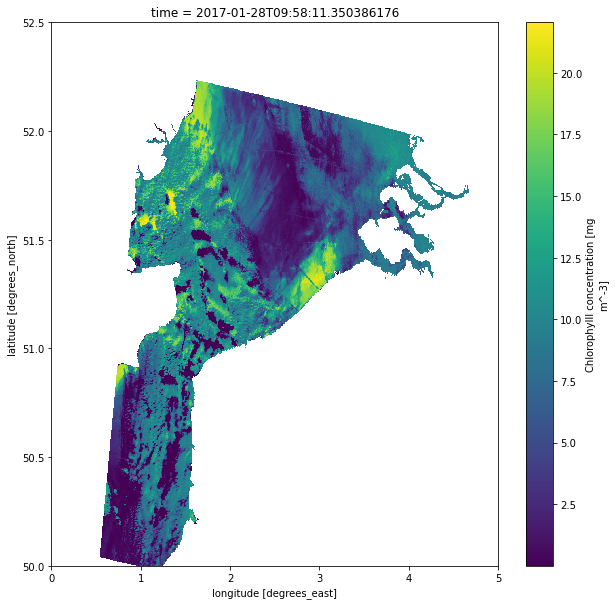

In [14]:
dataset.conc_chl.isel(time=3).plot.imshow(figsize=(10, 10))

### Writing data into a store

Let's create a new dataset as a spatial subset of the first:

In [15]:
new_dataset = dataset.sel(lon=slice(2.8, 4.75), lat=slice(52.1, 51.2))
new_dataset

<xarray.Dataset>
Dimensions:        (bnds: 2, lat: 360, lon: 780, time: 5)
Coordinates:
  * lat            (lat) float64 52.1 52.1 52.09 52.09 ... 51.21 51.21 51.2 51.2
    lat_bnds       (lat, bnds) float64 dask.array<chunksize=(90, 2), meta=np.ndarray>
  * lon            (lon) float64 2.801 2.804 2.806 2.809 ... 4.744 4.746 4.749
    lon_bnds       (lon, bnds) float64 dask.array<chunksize=(130, 2), meta=np.ndarray>
  * time           (time) datetime64[ns] 2017-01-16T10:09:21.834255872 ... 20...
    time_bnds      (time, bnds) datetime64[ns] dask.array<chunksize=(1, 2), meta=np.ndarray>
Dimensions without coordinates: bnds
Data variables:
    c2rcc_flags    (time, lat, lon) float64 dask.array<chunksize=(1, 90, 130), meta=np.ndarray>
    conc_chl       (time, lat, lon) float64 dask.array<chunksize=(1, 90, 130), meta=np.ndarray>
    quality_flags  (time, lat, lon) float64 dask.array<chunksize=(1, 90, 130), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.7

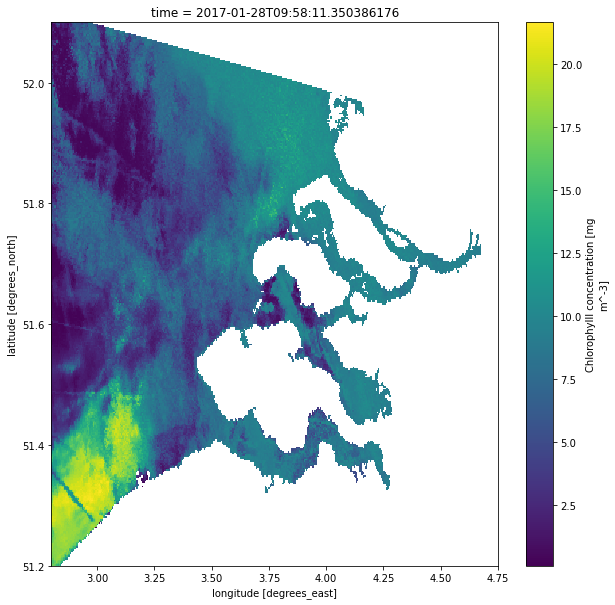

In [16]:
new_dataset.conc_chl.isel(time=3).plot.imshow(figsize=(10, 10))

And let's also drop empty time slices (will drop 2 empty slices):

In [17]:
new_dataset = new_dataset.dropna('time', how='all')
new_dataset

<xarray.Dataset>
Dimensions:        (bnds: 2, lat: 360, lon: 780, time: 3)
Coordinates:
  * lat            (lat) float64 52.1 52.1 52.09 52.09 ... 51.21 51.21 51.2 51.2
    lat_bnds       (lat, bnds) float64 dask.array<chunksize=(90, 2), meta=np.ndarray>
  * lon            (lon) float64 2.801 2.804 2.806 2.809 ... 4.744 4.746 4.749
    lon_bnds       (lon, bnds) float64 dask.array<chunksize=(130, 2), meta=np.ndarray>
  * time           (time) datetime64[ns] 2017-01-16T10:09:21.834255872 ... 20...
    time_bnds      (time, bnds) datetime64[ns] dask.array<chunksize=(1, 2), meta=np.ndarray>
Dimensions without coordinates: bnds
Data variables:
    c2rcc_flags    (time, lat, lon) float64 dask.array<chunksize=(1, 90, 130), meta=np.ndarray>
    conc_chl       (time, lat, lon) float64 dask.array<chunksize=(1, 90, 130), meta=np.ndarray>
    quality_flags  (time, lat, lon) float64 dask.array<chunksize=(1, 90, 130), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.7

We can write data to a store using the store's `write_data(data_id, **write_params)` method. Again, it can take store-specific write parameters:

In [18]:
store.get_write_data_params_schema()

There are no mandatory write parameters, so we can go without any. The format will be Zarr as this is xcube's default for data resources of type `xarray.Dataset`. 

Unfortunately, subsetting the data has changed its internal chunking in way that is incompatible with Zarr. So we need to rechunk the datasets first using xcube's `chunk_dataset` function, so finally all chunks of all variables have equal dimensions.

In [19]:
from xcube.core.chunk import chunk_dataset
new_dataset = chunk_dataset(new_dataset, dict(lat=90, lon=90, time=1), format_name='zarr')

Now we can write without errors. The write method returns the `data_id` of the data just being written:

In [20]:
store.write_data(new_dataset, 'cube-1-250-250-subset.zarr', replace=True)

'cube-1-250-250-subset.zarr'

Make sure it is in the store:

In [21]:
list(store.get_data_ids())

[('cube-1-250-250-subset.zarr', None),
 ('cube-1-250-250.zarr', None),
 ('cube-5-100-200.zarr', None),
 ('cube.nc', None)]

### Deleting data from a store

Deleting data works as expected:

In [22]:
store.delete_data('cube-1-250-250-subset.zarr')

In [23]:
JSON(list(store.get_data_ids()))

<IPython.core.display.JSON object>